In [115]:
%pylab inline
import emcee
import seaborn as sns
sns.set(style='ticks', context='notebook', font_scale=1.5, font='serif')

Populating the interactive namespace from numpy and matplotlib


/Users/maxisi/custompy3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['ndim', 'time', 'fmin', 'fmax']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Measuring amplitudes while overestimating the noise

## Fake data

Simulate a simple sinusoid signal in Gaussian noise with unit variance.

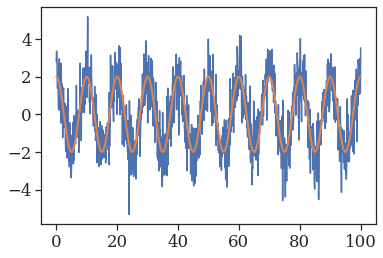

In [128]:
true_sigma = 1
true_amp = 2
true_f = 0.1

time = np.linspace(0, 100, 1000)
signal = true_amp * np.cos(2*np.pi*true_f*time) 
data = signal + np.random.normal(0, true_sigma, len(time))

plot(time, data);
plot(time, signal, lw=2);

## Signal amplituce estimate

Define a likelihood function that overestimates the variance by 50%.

In [129]:
fake_sigma = 1.5
Amin, Amax = 0.5, 5

def loglike(amp, data, sigma):
    if Amin < amp < Amax:
        r = (data - amp * np.cos(2*np.pi*true_f*time)) / sigma
        return -0.5 * np.dot(r, r)
    else:
        return -np.inf

ndim, nwalkers = 1, 100

def iter_sample(sigma, n=1):
    ''' Fit data with emcee n times, varying the noise.
    '''
    all_samples = []
    for i in range(n):
        p0 = np.random.uniform(Amin, Amax, (nwalkers, 1))
        sampler = emcee.EnsembleSampler(nwalkers, ndim, loglike, args=[data, sigma])
        # burn-in
        state = sampler.run_mcmc(p0, 100)
        sampler.reset()
        # sample
        sampler.run_mcmc(state, 2000);
        all_samples.append(sampler.get_chain(flat=True)[:,0])
    return all_samples

Samples this and see what we get for the amplitude posterior.

In [130]:
samples_dict = {
    r'Right $\sigma$': iter_sample(true_sigma)[0],
    r'Wrong $\sigma$': iter_sample(fake_sigma)[0],
}

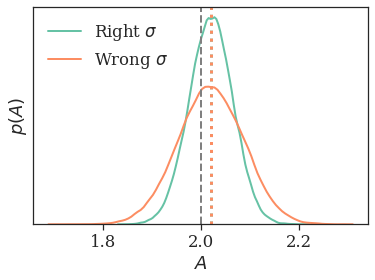

In [131]:
p = sns.color_palette('Set2', n_colors=2)

for c, (k, samples) in zip(p, samples_dict.items()):
    sns.distplot(samples, hist=False, label=k, color=c, kde_kws={'lw': 2})
    plt.gca().axvline(np.mean(samples), ls=':', lw=3, c=c)
    
plt.xlabel(r"$A$")
plt.ylabel(r"$p(A)$")
ax = plt.gca()
ax.axvline(true_amp, c='gray', ls='--', lw=2)
ax.set_yticks([]);
legend(frameon=False)

Overestimating the noise variance (like overestimating the PSD) leads us to overestimate the _uncertainty_ in the signal amplitude, but there's no systematic bias.

## SNR computation

Even though our estimate of the amplitude is not biased, assuming the wrong variance leads us to understimate the SNR of the signal by a factor equal to the ratio of standard deviations:

$\rho_{\rm true} \propto 1/\sigma_{\rm true}$ and $\rho_{\rm false} \propto 1/\sigma_{\rm false}$; therefore, trivially, $\rho_{\rm true} / \rho_{\rm false} = \sigma_{\rm false} / \sigma_{\rm true}$.